# IMPORTANT NOTE

unless you want to re-compute image embeddings, go to [calculate the similarity](#Calculate-the-Similarity) to run experiments

In [1]:
import torch
import clip
from PIL import Image
from torchvision import transforms

assert torch.cuda.is_available()
device = "cuda:3" #if torch.cuda.is_available() else "cpu"

/home/adavies4/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# !wget https://github.com/openai/CLIP/raw/main/CLIP.png

## CLIP Test Code
https://github.com/openai/CLIP#usage

The model returned by `clip.load()` supports the following methods:

#### `model.encode_image(image: Tensor)`

Given a batch of images, returns the image features encoded by the vision portion of the CLIP model.

#### `model.encode_text(text: Tensor)`

Given a batch of text tokens, returns the text features encoded by the language portion of the CLIP model.

#### `model(image: Tensor, text: Tensor)`

Given a batch of images and a batch of text tokens, returns two Tensors, containing the logit scores corresponding to each image and text input. The values are cosine similarities between the corresponding image and text features, times 100.



In [3]:
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

/home/adavies4/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Label probs: [[0.9927   0.004253 0.003016]]


In [4]:
image_features.shape

torch.Size([1, 512])

In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa85ca61f30>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

This function has to be changed to match the way ImageNet-C was created, see
- https://github.com/hendrycks/robustness/blob/master/ImageNet-C/create_c/make_imagenet_c.py
- https://github.com/hendrycks/robustness/blob/master/ImageNet-C/test.py

In [6]:
# We use also don't use the mean and std from CLIP
# mean=[0.48145466, 0.4578275, 0.40821073]
# std=[0.26862954, 0.26130258, 0.27577711]

# We use the standard imagenet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocess = transforms.Compose([
    transforms.Resize(256), # this is different than the 224 done above, I don't know why ImageNet-C did this
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])
preprocess

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [7]:
preprocess

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [8]:
# don't do the center crop for ImageNet-C, already done in creating the images
imagenet_c_preprocess = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])
imagenet_c_preprocess

Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

## ImageNet and ImageNet-C Dataloaders
`wget https://zenodo.org/record/2235448/files/blur.tar?download=1 -O /shared/timan108/imagenet_c/blur.tar`

`wget https://zenodo.org/record/2235448/files/noise.tar?download=1 -O /shared/timan108/imagenet_c/noise.tar`

In [9]:
import json
# !wget https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
with open("imagenet-simple-labels.json", "r") as f:
    idx2label_simple = json.load(f)

In [10]:
from torchvision import datasets
from tqdm import tqdm

batch_size=256

imagenet_val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(root="/shared/timan108/imagenet/images/val_by_synset",transform=preprocess),
    batch_size=batch_size, 
    shuffle=False)

imagenet_c_val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(root="/shared/timan108/imagenet_c/defocus_blur/3",transform=imagenet_c_preprocess),
    batch_size=batch_size, 
    shuffle=False)

In [11]:
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

inv_normalize = transforms.Normalize(
   mean = -1 * np.array(mean) / np.array(std),
   std = 1/np.array(std)
)

def imshow(img):
        inv_tensor = inv_normalize(img)
        npimg = inv_tensor.numpy()
        plt.figure(figsize=(20, 4), dpi=80)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off'),plt.show()

def show_examples(dataloader):
    # https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    n_examples = 7
    images, labels = next(iter(dataloader))
    print(f"Feature batch shape: {images.size()}")
    print(f"Labels batch shape: {labels.size()}")
    imshow(torchvision.utils.make_grid(images[:n_examples]))
    print(' '.join(f'{labels[j]}' for j in range(n_examples)))
    print(' '.join(f'{idx2label_simple[labels[j]]}' for j in range(n_examples)))

Feature batch shape: torch.Size([256, 3, 224, 224])
Labels batch shape: torch.Size([256])


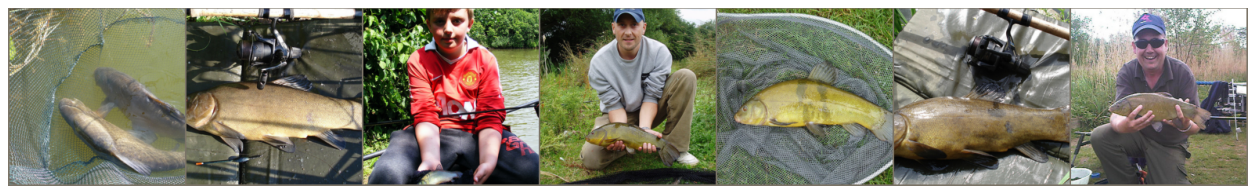

0 0 0 0 0 0 0
tench tench tench tench tench tench tench


In [12]:
show_examples(imagenet_val_loader)

Feature batch shape: torch.Size([256, 3, 224, 224])
Labels batch shape: torch.Size([256])


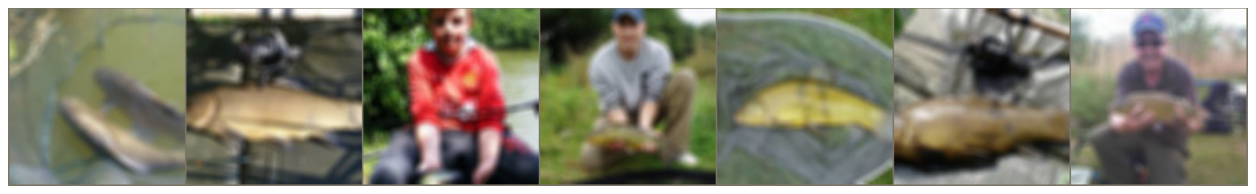

0 0 0 0 0 0 0
tench tench tench tench tench tench tench


In [13]:
show_examples(imagenet_c_val_loader)

In [ ]:
# test to see if there are any missing images by looking at the last image in the entire data
# imshow(datasets.ImageFolder(root="/shared/timan108/imagenet_c/defocus_blur/3",transform=preprocess)[-1][0])
# imshow(datasets.ImageFolder(root="/shared/timan108/imagenet/images/val_by_synset",transform=preprocess)[-1][0])

## Generate CLIP image embeddings
Alternative get_features function here: 
https://github.com/openai/CLIP/blob/main/README.md#linear-probe-evaluation

In [ ]:
len(imagenet_val_loader.dataset), len(imagenet_c_val_loader.dataset)

In [ ]:
def generate_features(data_loader):
    n_batch_size = data_loader.batch_size
    n_batches = len(data_loader)
    n_images = len(data_loader.dataset)
    n_feature_dim = 512
    features = torch.zeros(n_images, n_feature_dim).to(device)
    for i, (batch, target) in tqdm(enumerate(data_loader), total=n_batches):
        with torch.no_grad():
            start = i*n_batch_size
            features[start:start+batch.shape[0]] = model.encode_image(batch.to(device))
    return features

In [ ]:
# imagenet_features = generate_features(imagenet_val_loader)
# torch.save(imagenet_features, 'imagenet_features.pt')

In [ ]:
# imagenet_c_features = generate_features(imagenet_c_val_loader)
# torch.save(imagenet_c_features, 'imagenet_c_features.pt')

In [ ]:
# diff_features = imagenet_features - imagenet_c_features
# torch.save(diff_features, 'diff_features.pt')

# Calculate the Similarity

cf. https://github.com/openai/CLIP/blob/main/README.md#zero-shot-prediction

In [6]:
# reload everything in case we didn't run all code (e.g. re-compute embeddings, etc.) above

import torchvision
import math
import json
import torch
# import clip
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from PIL import Image
from torchvision import transforms
from torchvision import datasets
from tqdm import tqdm

# assert torch.cuda.is_available()
# device = "cuda:3" #if torch.cuda.is_available() else "cpu"

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [36]:
def cosine_similarity(x,y):
#     x /= x.norm(dim=-1, keepdim=True)
#     y /= y.norm(dim=-1, keepdim=True)
    return (x @ y.T) / (x.norm(dim=-1, keepdim=True) * y.norm(dim=-1, keepdim=True))

def yeet(tensor, to_numpy=True):
    if to_numpy:
        return tensor.detach().cpu().numpy()
    else:
        return tensor.detach().cpu()

In [37]:
feature_dir = '/shared/timan108/clip_embeddings/'

# x = torch.load('imagenet_features.pt')
# x = torch.load('diff_features.pt')
imagenet_features = yeet(torch.load(f'{feature_dir}/imagenet_features.pt'), to_numpy=False)
diff_features = yeet(torch.load(f'{feature_dir}/diff_features.pt'), to_numpy=False)

In [7]:
# bfm = cosine_similarity(x,x)
bfm_imgnet = yeet(cosine_similarity(imagenet_features, imagenet_features))
bfm_diff = yeet(cosine_similarity(diff_features, diff_features))

In [33]:
# bfm.shape
bfm_imgnet.shape, bfm_diff.shape

(torch.Size([50000, 50000]), torch.Size([50000, 50000]))

In [52]:
# bfm.triu_(1)
torch.Tensor(bfm_imgnet).triu_(1), torch.Tensor(bfm_diff).triu_(1)

(tensor([[0.0000, 0.7707, 0.6249,  ..., 0.4956, 0.6207, 0.5069],
         [0.0000, 0.0000, 0.6477,  ..., 0.4529, 0.4748, 0.4706],
         [0.0000, 0.0000, 0.0000,  ..., 0.4308, 0.4730, 0.4162],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5246, 0.6051],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4936],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[ 0.0000,  0.4137,  0.4565,  ...,  0.1539,  0.5881,  0.2102],
         [ 0.0000,  0.0000,  0.4488,  ...,  0.0276,  0.3301,  0.2882],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0723,  0.4369,  0.1987],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.1185, -0.0033],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.2084],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]))

In [36]:
# bfm = yeet(bfm)
# sim_sum = bfm.sum()

In [8]:
# nz_bfm = bfm[bfm != 0]
nonzero_bfm_imgnet = bfm_imgnet[bfm_imgnet != 0]
nonzero_bfm_diff = bfm_diff[bfm_diff != 0]

In [9]:
len(nonzero_bfm_imgnet), len(nonzero_bfm_diff)

(2500000000, 2500000000)

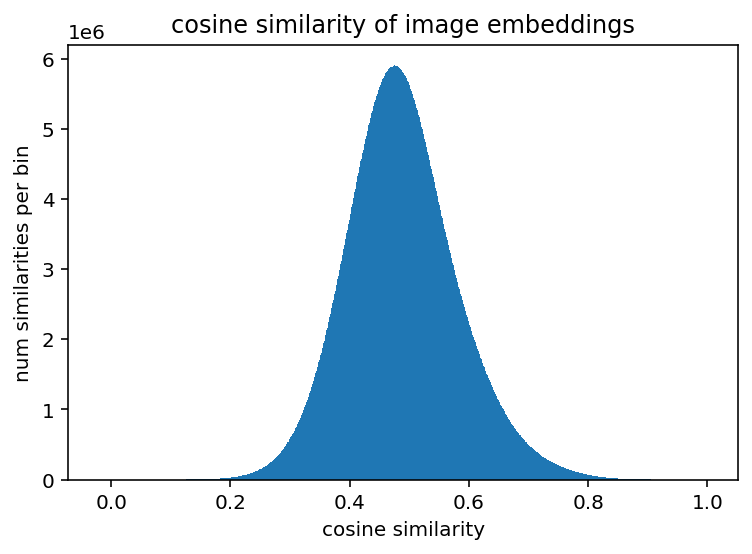

In [46]:
# this is just the cosine similarity of all imagenet val clip embeddings to each other  
plt.figure()
# plt.hist(nz_bfm, bins=1000)
plt.hist(nonzero_bfm_imgnet, bins=1000)
plt.title('cosine similarity of image embeddings')
plt.xlabel('cosine similarity')
plt.ylabel('num similarities per bin')
plt.show()

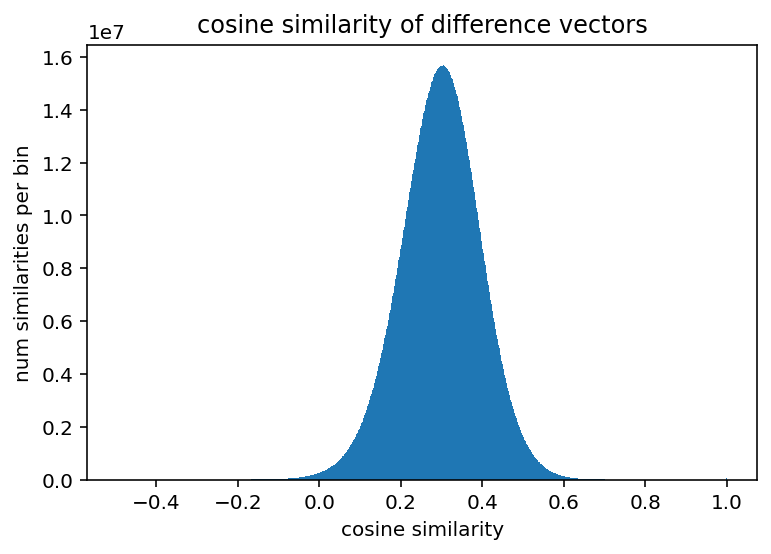

In [47]:
# cosine similarity of all difference between distorted and undistorted clip embeddings to each other  
plt.figure()
# plt.hist(nz_bfm, bins=1000)
plt.hist(nonzero_bfm_diff, bins=1000)
plt.title('cosine similarity of difference vectors')
plt.xlabel('cosine similarity')
plt.ylabel('num similarities per bin')
plt.show()

the mean > 0 so there is a simularity between all the difference vectors for imagenet val


(an)isotropic embedding spaces? 

In [20]:
# mean = nz_bfm.mean()
# std = nz_bfm.std()

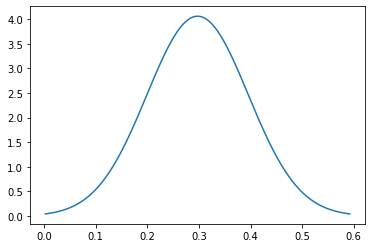

In [49]:
# mu = mean
# variance = std**2
# sigma = math.sqrt(variance)
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# plt.plot(x, stats.norm.pdf(x, mu, sigma))
# plt.show()

## plots occurring in paper

### OG experiments

In [10]:
imgnet_hist, imgnet_bins = np.histogram(nonzero_bfm_imgnet, bins=1000)
imgnet_hist = imgnet_hist.astype(np.float32) / imgnet_hist.sum()
diff_hist, diff_bins = np.histogram(nonzero_bfm_diff, bins=1000)
diff_hist = diff_hist.astype(np.float32) / diff_hist.sum()

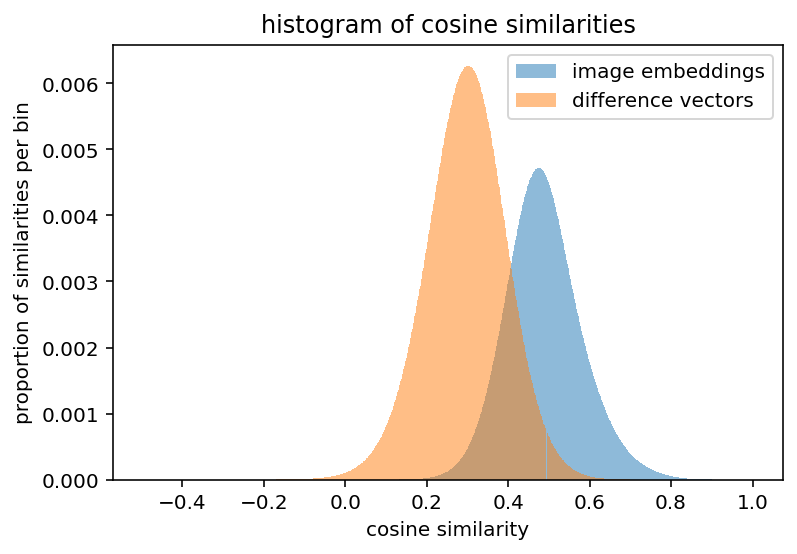

In [96]:
fig, ax = plt.subplots()
ax.bar(imgnet_bins[:-1], imgnet_hist, width=(imgnet_bins[1]-imgnet_bins[0]), alpha=0.5)
ax.bar(diff_bins[:-1], diff_hist, width=(diff_bins[1]-diff_bins[0]), alpha=0.5)
ax.legend(['image embeddings', 'difference vectors'])
ax.set_title('histogram of cosine similarities')
ax.set_xlabel('cosine similarity')
ax.set_ylabel('proportion of similarities per bin')
fig.show()

In [77]:
nonzero_bfm_imgnet.mean(), nonzero_bfm_imgnet.std()

(0.4878739, 0.09304284)

In [78]:
nonzero_bfm_diff.mean(), nonzero_bfm_diff.std()

(0.29740342, 0.09835312)

Why is difference vectors hist taller? It should be the other way around... Let's normalize for it below, I guess.

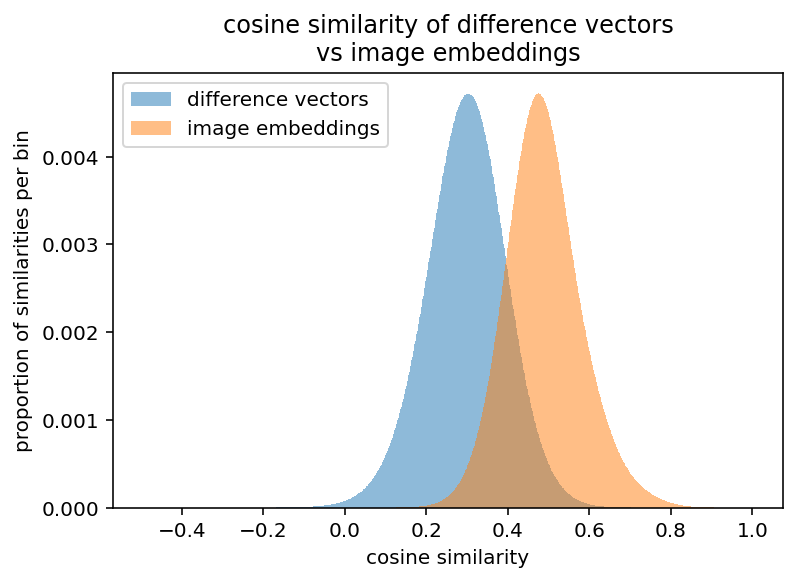

In [106]:
fig, ax = plt.subplots()
# ax.hist(nonzero_bfm_imgnet, bins=1000, density=True, weights=hist1_weights, alpha=0.5)
# ax.hist(nonzero_bfm_diff, bins=1000, density=True, weights=hist2_weights, alpha=0.5)
hist1_weights = np.ones_like(nonzero_bfm_imgnet)/float(len(nonzero_bfm_imgnet))
hist2_weights = np.ones_like(nonzero_bfm_diff)/float(len(nonzero_bfm_diff))
hist2_weights *= np.max(imgnet_hist) / np.max(diff_hist)  # why this is necessary, I do not know
ax.hist(nonzero_bfm_diff, bins=1000, density=False, weights=hist2_weights, alpha=0.5)
ax.hist(nonzero_bfm_imgnet, bins=1000, density=False, weights=hist1_weights, alpha=0.5)
ax.legend(['difference vectors', 'image embeddings'])
ax.set_title('cosine similarity of difference vectors\nvs image embeddings')
ax.set_xlabel('cosine similarity')
ax.set_ylabel('proportion of similarities per bin')
fig.show()

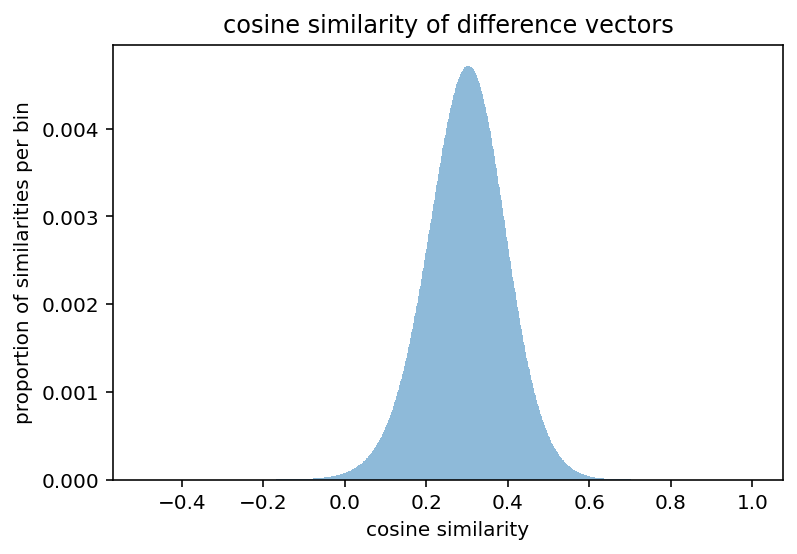

In [99]:
fig, ax = plt.subplots()
# ax.hist(nonzero_bfm_imgnet, bins=1000, density=False, weights=hist1_weights, alpha=0.5)
ax.hist(nonzero_bfm_diff, bins=1000, density=False, weights=hist2_weights, alpha=0.5)
ax.set_title('cosine similarity of difference vectors')
ax.set_xlabel('cosine similarity')
ax.set_ylabel('proportion of similarities per bin')
fig.show()

### new experiments (on May 09)

In [47]:
diff_norms = yeet(diff_features.norm(dim=-1))
diff_norms, diff_norms.shape

(array([5.6727934, 6.188609 , 6.934359 , ..., 5.7313313, 5.3330216,
        8.453433 ], dtype=float32),
 (50000,))

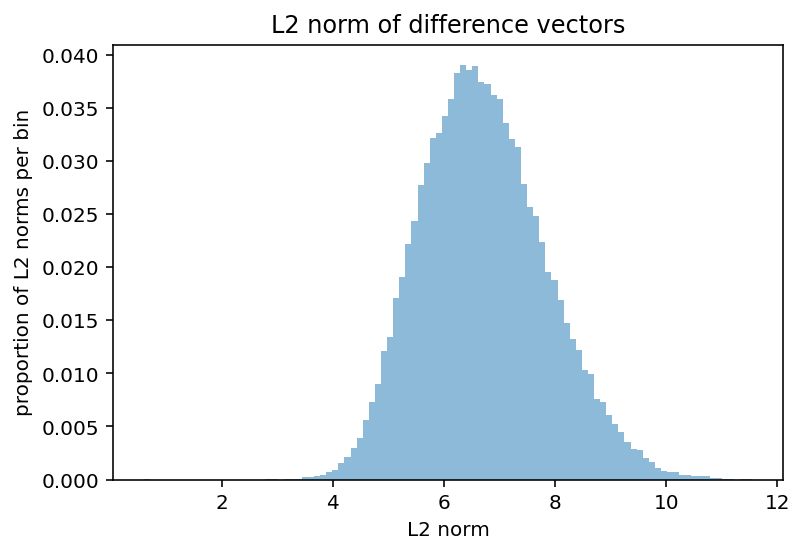

In [55]:
fig, ax = plt.subplots()
hist_weights = np.ones_like(diff_norms)/float(len(diff_norms))
# hist2_weights = np.ones_like(nonzero_bfm_diff)/float(len(nonzero_bfm_diff))
# hist2_weights *= np.max(imgnet_hist) / np.max(diff_hist)  # why this is necessary, I do not know
ax.hist(diff_norms, bins=100, density=False, weights=hist_weights, alpha=0.5)
# ax.legend(['difference vectors', 'image embeddings'])
ax.set_title('L2 norm of difference vectors')
ax.set_xlabel('L2 norm')
ax.set_ylabel('proportion of L2 norms per bin')
fig.show()

In [19]:
imagenet_c_features = yeet(torch.load(f'{feature_dir}/imagenet_c_features.pt'), to_numpy=False)
bfm_imgnet_c = yeet(cosine_similarity(imagenet_c_features, imagenet_c_features))
nonzero_bfm_imgnet_c = bfm_imgnet_c[bfm_imgnet_c != 0]

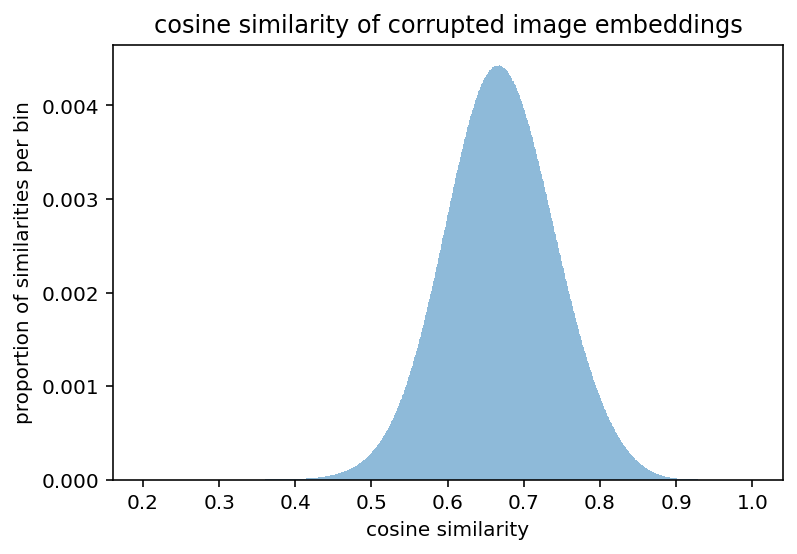

In [20]:
fig, ax = plt.subplots()
hist_weights = np.ones_like(nonzero_bfm_imgnet_c)/float(len(nonzero_bfm_imgnet_c))
# hist2_weights = np.ones_like(nonzero_bfm_diff)/float(len(nonzero_bfm_diff))
# hist2_weights *= np.max(imgnet_hist) / np.max(diff_hist)  # why this is necessary, I do not know
ax.hist(nonzero_bfm_imgnet_c, bins=1000, density=False, weights=hist_weights, alpha=0.5)
# ax.legend(['difference vectors', 'image embeddings'])
ax.set_title('cosine similarity of corrupted image embeddings')
ax.set_xlabel('cosine similarity')
ax.set_ylabel('proportion of similarities per bin')
fig.show()

In [21]:
bfm_compare = yeet(cosine_similarity(imagenet_features, imagenet_c_features))
nonzero_bfm_compare = bfm_compare[bfm_compare != 0]

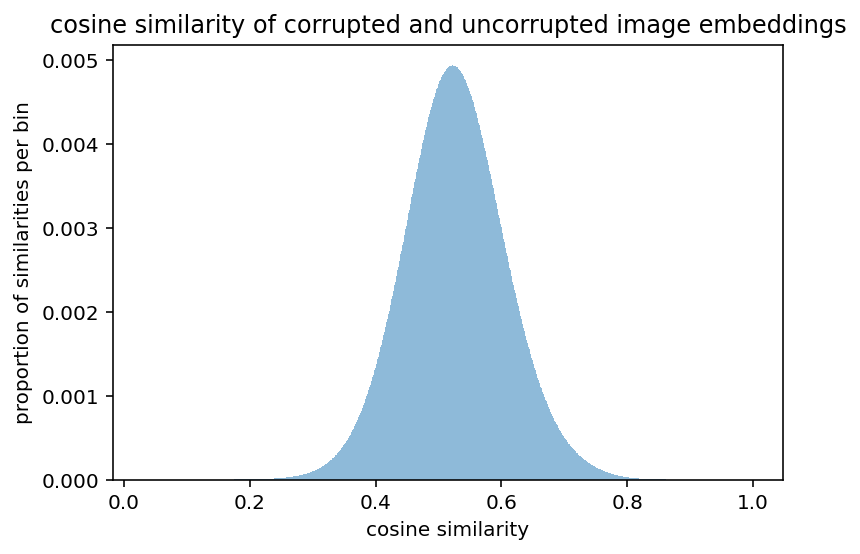

In [23]:
fig, ax = plt.subplots()
hist_weights = np.ones_like(nonzero_bfm_compare)/float(len(nonzero_bfm_compare))
# hist2_weights = np.ones_like(nonzero_bfm_diff)/float(len(nonzero_bfm_diff))
# hist2_weights *= np.max(imgnet_hist) / np.max(diff_hist)  # why this is necessary, I do not know
ax.hist(nonzero_bfm_compare, bins=1000, density=False, weights=hist_weights, alpha=0.5)
# ax.legend(['difference vectors', 'image embeddings'])
ax.set_title('cosine similarity of corrupted and uncorrupted image embeddings')
ax.set_xlabel('cosine similarity')
ax.set_ylabel('proportion of similarities per bin')
fig.show()

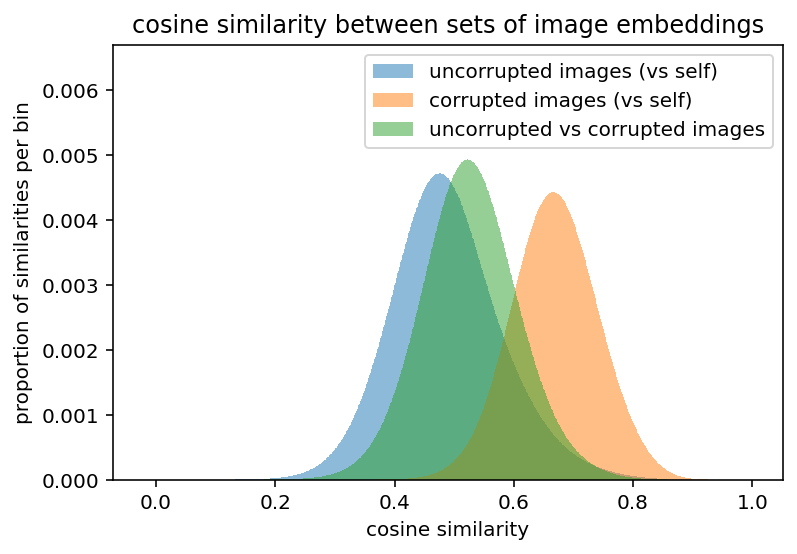

In [32]:
# https://stackoverflow.com/questions/43677729/matplotlib-extend-best-positioning-also-outside-the-plot
def legend_adjust(legend, ax=None, pad=0.05):
    if ax == None:
        ax = plt.gca()
    ax.figure.canvas.draw()
    bbox = legend.get_window_extent().transformed(ax.transAxes.inverted())
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax+(ymax-ymin)*(1.+pad-bbox.y0))

fig, ax = plt.subplots()
assert len(nonzero_bfm_imgnet) == len(nonzero_bfm_imgnet_c) == len(nonzero_bfm_compare)
hist_weights = np.ones_like(nonzero_bfm_imgnet)/float(len(nonzero_bfm_imgnet))
# hist2_weights = np.ones_like(nonzero_bfm_diff)/float(len(nonzero_bfm_diff))
# hist2_weights *= np.max(imgnet_hist) / np.max(diff_hist)  # why this is necessary, I do not know
ax.hist(nonzero_bfm_imgnet, bins=1000, density=False, weights=hist_weights, alpha=0.5)
ax.hist(nonzero_bfm_imgnet_c, bins=1000, density=False, weights=hist_weights, alpha=0.5)
ax.hist(nonzero_bfm_compare, bins=1000, density=False, weights=hist_weights, alpha=0.5)
legend = ax.legend(['uncorrupted images (vs self)', 'corrupted images (vs self)', 
                    'uncorrupted vs corrupted images'])
legend_adjust(legend, ax)
ax.set_title('cosine similarity between sets of image embeddings')
ax.set_xlabel('cosine similarity')
ax.set_ylabel('proportion of similarities per bin')
fig.show()